To demonstrate the issue, a simplified task was devised.

The price graph consists of 6 points (price[0, 2, 1, 0, 2, 1]).

The values of a certain feature are sequential numbers: 1, 2, 3, 4, 5, 6.

In case of a purchase, the exit occurs on the next step forcibly.

We are training only the entry network (finding the policy) for entering a position (buying).

Question:

What needs to be done for the model to achieve the maximum total reward (equal to 4, not the local maximum of 2)?

In [64]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [65]:
class StockEnv:
    def __init__(self, df: pd.DataFrame):
        super().__init__()
        self.df = df  # Columns "time" and "price" are required, other columns are features for the model.
        self.action_size = 2  # no action(no buy) and buy
        self.state_size = df.shape[1] - 2

    @property
    def state(self):
        return self.df.drop(columns=["time", "price"]).iloc[self.current_step].values

    def step(self, action):  # done = next_state is None
        reward, info = 0.0, {}
        if action == 1:
            if self.in_position == 1:
                reward = self.df.iloc[self.current_step].price - self.df.iloc[self.entry_step].price
                info["trade"] = (self.entry_step, self.current_step)
            else:
                self.entry_step = self.current_step
            self.in_position = 1 - self.in_position  # Swap 0 and 1

        self.current_step += 1
        next_state = self.state if self.current_step < len(self.df) else None
        return next_state, reward, info

    def reset(self):
        self.current_step = 0
        self.in_position, self.entry_step = 0, None
        return self.state

In [66]:
class StockOperator:  # Agent
    def __init__(self, env: StockEnv, hidden_size: int = 512, learning_rate: float = 1e-3):
        self.env = env
        self.entry_policy = nn.Sequential(nn.Linear(env.state_size, hidden_size), nn.LeakyReLU(), nn.Linear(hidden_size, env.action_size), nn.Softmax(dim=-1))
        self.entry_optim = torch.optim.AdamW(self.entry_policy.parameters(), lr=learning_rate, weight_decay=0.0)
        self.clear_memory()
        self.epoch_rewards = []

    def set_learning_rate(self, lr: float):
        for g in self.entry_optim.param_groups:
            g["lr"] = lr

    def clear_memory(self):
        self.entry_memory_rewards, self.entry_memory_states, self.entry_memory_actions = np.array([]), np.array([]), np.array([])
        self.memory_episode_count = 0

    @torch.no_grad()
    def select_action(self, state):
        if self.env.in_position:
            return 1  # always close on the next step if there is a position
        probs = self.entry_policy(torch.FloatTensor(state.reshape(-1, 1)))
        return torch.multinomial(probs, 1).item()

    @torch.no_grad()
    def play_episodes(self, episodes, clear_memory: bool = False):
        if clear_memory:
            self.clear_memory()
        epoch_reward = 0.0
        for _ in range(episodes):
            state = self.env.reset()
            rewards, states, actions, in_position = [], [], [], []
            while state is not None:
                action = self.select_action(state)
                in_position.append(self.env.in_position)
                next_state, reward, _ = self.env.step(action)
                rewards.append(reward)
                states.append(state)
                actions.append(action)
                state = next_state
            epoch_reward += np.sum(rewards)

            for i in range(len(rewards) - 1)[::-1]:
                rewards[i] += rewards[i + 1]

            in_position = np.array(in_position)
            rewards = np.array(rewards)
            states = np.array(states)
            actions = np.array(actions)

            self.entry_memory_rewards = np.append(self.entry_memory_rewards, rewards[in_position == 0])
            self.entry_memory_states = np.append(self.entry_memory_states, states[in_position == 0])
            self.entry_memory_actions = np.append(self.entry_memory_actions, actions[in_position == 0])

            self.memory_episode_count += 1
        self.epoch_rewards.append(epoch_reward / self.memory_episode_count)

    def train(self, epochs, episodes_in_epoch):
        for _ in range(epochs):
            self.play_episodes(episodes_in_epoch, clear_memory=True)

            probs = self.entry_policy(torch.FloatTensor(self.entry_memory_states.reshape(-1, 1)))
            log_probs = torch.log(probs[range(len(probs)), np.array(self.entry_memory_actions)] + 1e-10)
            loss = -(torch.FloatTensor(np.array(self.entry_memory_rewards)) * log_probs).mean()
            self.entry_optim.zero_grad()
            loss.backward()
            self.entry_optim.step()

            self.render()
            
    @torch.no_grad()
    def render(self):
        # Render the environment to the screen
        clear_output(wait=True)

        plt.figure(figsize=(16, 9))
        plt.suptitle(f"Stock price - 6 points problem")
        # First plot: stock prices and trade actions
        plt.subplot(2, 2, 1)
        plt.plot(self.env.df.time, self.env.df.price, marker=".", c="lightgray", alpha=0.5)
        state = self.env.reset()
        total_reward = 0.0
        while state is not None:
            action = self.select_action(state)
            state, reward, info = self.env.step(action)
            total_reward += reward
            if "trade" in info:
                trade = info["trade"]
                color = ["g", "r"][int(self.env.df.iloc[trade[1]].price < self.env.df.iloc[trade[0]].price)]
                plt.plot(
                    [self.env.df.iloc[trade[0]].time, self.env.df.iloc[trade[1]].time],
                    [self.env.df.iloc[trade[0]].price, self.env.df.iloc[trade[1]].price],
                    color=color,
                )
        plt.title(f"One episode, total episode reward = {total_reward:.2f}")
        plt.xlabel("time")
        plt.ylabel("price")

        # Second plot: action probabilities of the model
        plt.subplot(2, 2, 2)
        X = torch.linspace(self.env.df.feature1.min(), self.env.df.feature1.max(), 100).reshape(-1, 1)
        Y = self.entry_policy(X).detach().numpy()[:, 1]
        plt.scatter(X, Y, c="g", marker=".", label="buy")
        plt.title(f"Policy buy probability")
        plt.xlabel("state")
        plt.ylabel("probability")
        plt.legend()

        # Third plot: Average reward by state without position
        plt.subplot(2, 2, 3)
        df_rew = pd.DataFrame({"action": self.entry_memory_actions, "reward": self.entry_memory_rewards, "state": self.entry_memory_states})
        dfg = df_rew.groupby(["action", "state"], as_index=False).mean()
        plt.plot(dfg[dfg.action == 1].state, dfg[dfg.action == 1].reward, label="buy (no position)", c="g")
        plt.axhline(y=0, c="lightgray", alpha=0.5)
        plt.plot(dfg[dfg.action == 0].state, dfg[dfg.action == 0].reward, label="no buy (no position)", c="g", linestyle="--")

        plt.title(f"Average state reward by {self.memory_episode_count} episodes")
        plt.xlabel("state")
        plt.ylabel("average reward")
        plt.legend()

        # Fourth plot: Average reward by state in position
        plt.subplot(2, 2, 4)
        plt.plot(self.epoch_rewards)
        plt.title(f"Average epoch reward (last epoch reward = {self.epoch_rewards[-1]:.2f})")
        plt.xlabel("epoch")
        plt.ylabel("average epoch reward")

        plt.tight_layout()
        plt.show()

In [67]:
prices = np.array([0, 2, 1, 0, 2, 1], dtype=float)

times = np.arange(len(prices)) + 1

df = pd.DataFrame({"time": times, "price": prices, "feature1": times})

env = StockEnv(df)
torch.manual_seed(20)
op = StockOperator(env)

In [68]:
#op.set_learning_rate(1e-5)

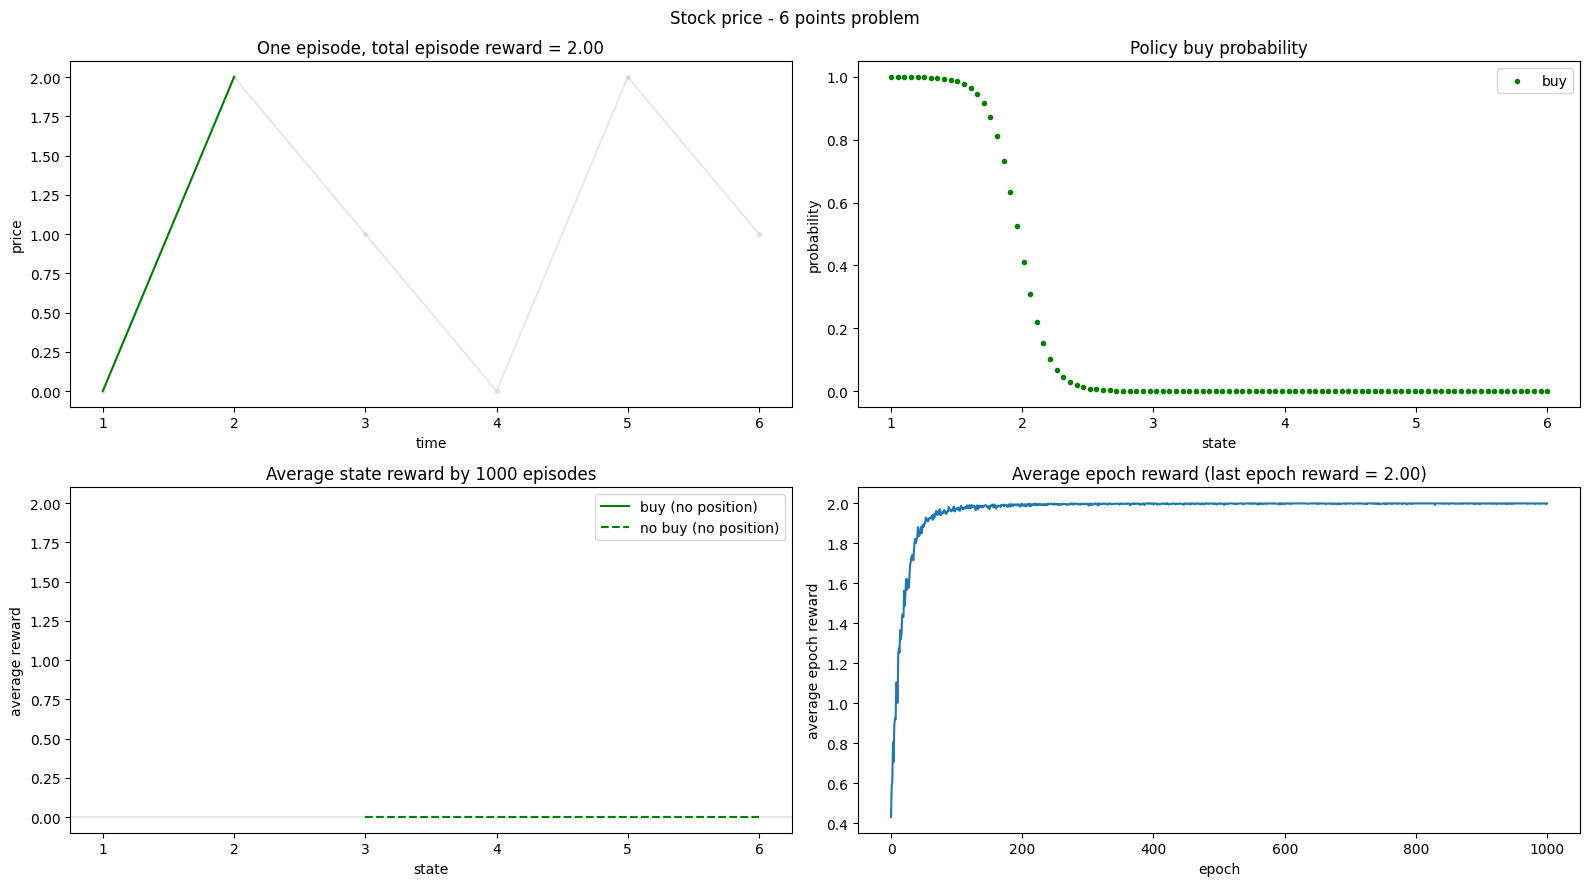

In [71]:
op.train(epochs=1000, episodes_in_epoch=1000)

In [70]:
# To evaluate the ability of the policy gradient method to reach the maximum total reward, we derived the complete formula for the total reward,
# as the task is simple and allows us to easily describe the entire state transition tree. Then, using the classic policy gradient approach 
# (starting with its initial formula), we directly maximized this function through a neural network.
# However, even with the exact reward function formula, the policy gradient method was only able to reach a local maximum, 
# whereas in the code below, we can easily manually set an intuitively clear policy that provides a global maximum of 4.
torch.manual_seed(20)
policy = nn.Sequential(nn.Linear(1, 512), nn.LeakyReLU(), nn.Linear(512, 2), nn.Softmax(dim=-1))
optim = torch.optim.Adam(policy.parameters())

#prices = [0, 2, 1, 0, 2, 1]
for _ in range(200):
    p1, p2, p3, p4, p5, p6 = policy(torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0, 6.0]).view(-1, 1))

    J = (
        p1[0] * p2[0] * p3[0] * p4[0] * p5[1] * (-1)
        + p1[0] * p2[0] * p3[0] * p4[1] * (2)
        + p1[0] * p2[0] * p3[1] * p5[0] * (-1)
        + p1[0] * p2[0] * p3[1] * p5[1] * (-1 - 1)
        + p1[0] * p2[1] * p4[0] * p5[0] * (-1)
        + p1[0] * p2[1] * p4[0] * p5[1] * (-1 - 1)
        + p1[0] * p2[1] * p4[1] * (2 - 1)
        + p1[1] * p3[0] * p4[0] * p5[0] * (2)
        + p1[1] * p3[0] * p4[0] * p5[1] * (2 - 1)
        + p1[1] * p3[0] * p4[1] * (2 + 2)
        + p1[1] * p3[1] * p5[0] * (2 - 1)
        + p1[1] * p3[1] * p5[1] * (2 - 2)
    )

    loss = -J
    loss.backward()
    optim.step()

print(J.item())

p1, p2, p3, p4, p5 = [0., 1.], [1., 0.], [1., 0.], [0., 1.], [1., 0.]
print(
    p1[0] * p2[0] * p3[0] * p4[0] * p5[1] * (-1)
    + p1[0] * p2[0] * p3[0] * p4[1] * (2)
    + p1[0] * p2[0] * p3[1] * p5[0] * (-1)
    + p1[0] * p2[0] * p3[1] * p5[1] * (-1 - 1)
    + p1[0] * p2[1] * p4[0] * p5[0] * (-1)
    + p1[0] * p2[1] * p4[0] * p5[1] * (-1 - 1)
    + p1[0] * p2[1] * p4[1] * (2 - 1)
    + p1[1] * p3[0] * p4[0] * p5[0] * (2)
    + p1[1] * p3[0] * p4[0] * p5[1] * (2 - 1)
    + p1[1] * p3[0] * p4[1] * (2 + 2)
    + p1[1] * p3[1] * p5[0] * (2 - 1)
    + p1[1] * p3[1] * p5[1] * (2 - 2)
)

1.9999946355819702
4.0
